# Project: Correct Rainfall amount from Rain Radar


### In this Notebook we will use a Neural Network to correct the rainfall amount derived by an indirect measurement i.e. Radar Reflectivity.

The standard method to derive precipitation amount at the ground from radar reflectivities is to use a Z/R relationship.
However, the calculated rainfall is not exactly displaying the observed amount of ground measurements.

We will try to correct the bias by using a Neural Network.
First we will load the necessary Python Packages...

In [1]:
import os 
os.environ['KERAS_BACKEND']='tensorflow'

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from IPython.display import clear_output

get_ipython().run_line_magic('matplotlib', 'inline')

import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, utils

from keras import layers
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Activation
from keras import regularizers
from keras.models import Sequential
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from keras.optimizers import SGD, Adadelta, Adagrad, RMSprop, Adam

from keras.utils import to_categorical




2024-03-17 13:46:42.141672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 13:46:43.478335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


updatable plot to visualize the loss function during training of a Neural Network model

In [3]:
# updatable plot
# a minimal example (sort of)
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()


## 1.) Data Preparation and Benchmark

Now we load a test dataset.  

It contains Radar Reflectivities (REFLECTIVITY) from a weather radar in a grid cell where ground observations (GROUND) exist.

To load the data we use the pandas function

    read_csv('path to dataset')


In [4]:
#Import the data
Hohenp = pd.read_csv('Data/Hohenp1h.csv')
#Hohenp = Hohenp.drop('index', 1)
#Hohenp.reset_index()
Hohenp.head()

,Unnamed: 0,index,MESS_DATUM,REFLECTIVITY,GROUND
0,0,4,2015-05-01 07:00:00,183.739594,1.0
1,1,5,2015-05-01 08:00:00,87.625786,0.5
2,2,6,2015-05-01 09:00:00,87.754196,0.4
3,3,7,2015-05-01 10:00:00,154.573288,0.5
4,4,8,2015-05-01 11:00:00,131.241669,0.5


The idea is now to use the reflectivity as input for a Neural network that has the ground observations as target.  
The NN model can then be interpreted as a transfer function which is suitable to calculate adequate rainfall amounts on the ground from reflectivities above.  

So we first extract the ground observations and the reflectivities from the dataset.

In [5]:
gr = np.array(Hohenp['GROUND'])
ref = np.array(Hohenp['REFLECTIVITY'])
ref

array([1.83739594e+02, 8.76257858e+01, 8.77541962e+01, ...,
       1.20000010e-02, 1.20000010e-02, 1.20000010e-02])

We use the standard Z-R relationship (used by the German Weather service) to derive the benchmark rain amount from measured reflectivities.

We will use the resulting precipitation amount as a benchmark to compare the performance of our Neural Network model witrh respect to the residual bias compared to the ground observations.


In [6]:
refzr = np.power(ref/256, (1.0 / 1.42))

In [7]:
# Correlation between Z-R and ground
np.corrcoef(refzr,gr)

array([[1.        , 0.63594825],
       [0.63594825, 1.        ]])

Let's visualize the Z/R-Precipitaion with the observed ground measurements.

We use the Python library matplotlib

The function

    plot(x-values, y-values, Options)

generates a scatter plot of Ground vs Z/R (Radar)

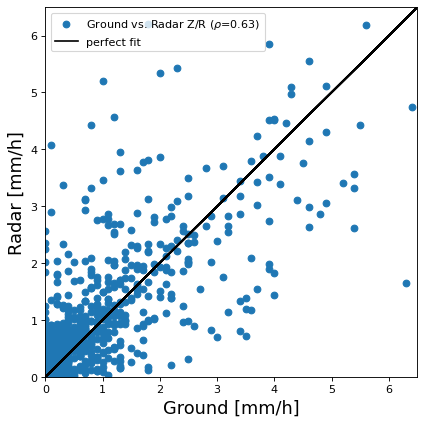

In [8]:
fig=plt.figure(figsize=(6, 6), dpi=80)
plt.xlim(0,6.5)
plt.ylim(0,6.5)

plt.scatter(gr,refzr,label='Ground vs. Radar Z/R ($ \\rho $=0.63)');
plt.plot(gr,gr,'-',color='black',label='perfect fit');
plt.xlabel('Ground [mm/h]', size=16);
plt.ylabel('Radar [mm/h]', size=16);
#plt.title('Hourly Data', size=18);
plt.legend(loc='upper left');

#fig.savefig('Plots/Scatter_Hourly_AllData.pdf', dpi=80)

The black line indicates a "perfect Fit".
That means in the case that the precipitation value calculated from the radar is exactly matching the ground observation, the resulting point in the scatter plot would lie on the black line.

Ground = Z-R Precip

However, we see that the Z-R relationship is able to reconstruct the overall structure but there are many examples where the ground rainfall is over-, or underestimated.  

Especially for larger precipitaion values the deviation can be quite large.

As an overall quality measure we can calculate the Pearson Correlation between Ground and Z-R Rainfall amounts.

We find that:  

$\rho = 0.63$

That means we have a moderate positive (linear) correlation for the complete dataset.

Another very important performance measure is the bias of a model.  

That means the deviation between the mean of the model output and the mean of the target values.

$𝐵𝑖𝑎𝑠=𝑚𝑒𝑎𝑛(𝑜𝑢𝑡𝑝𝑢𝑡)−𝑚𝑒𝑎𝑛(𝑔𝑟𝑜𝑢𝑛𝑑)$

In [9]:
MSE_ZR=mean_squared_error(refzr,gr)

bias_ZR=np.mean(refzr)-np.mean(gr)
corr_ZR=np.corrcoef(refzr,gr)[0,1]
print('bias:',bias_ZR,
      'MSE:',MSE_ZR,
     'corr:',corr_ZR)

bias: 0.05522979622961052 MSE: 1.1645797558435005 corr: 0.6359482497355617


A time series plot shows in detail how the estimated and true rainfall amounts look like:

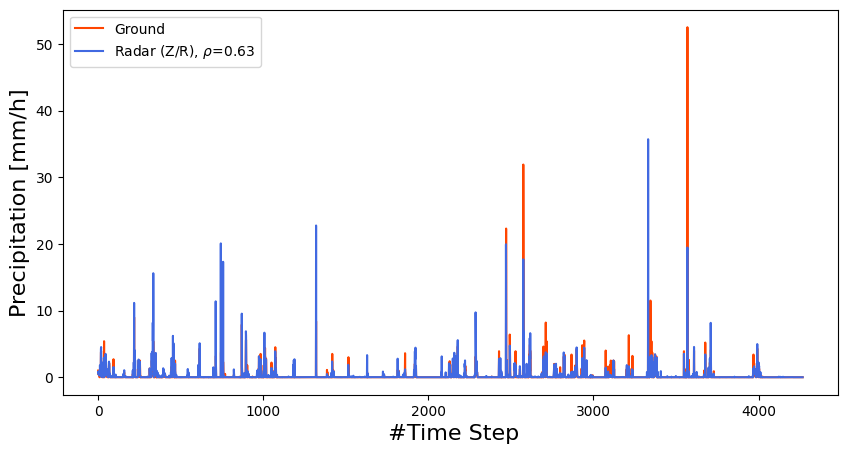

In [10]:
fig=plt.figure(figsize=(10, 5))

plt.plot(gr,'orangered',label='Ground')
plt.plot(refzr,'royalblue',label='Radar (Z/R), $ \\rho$=0.63')

plt.ylabel('Precipitation [mm/h]', size=16)
plt.xlabel(' #Time Step', size=16) 
#plt.title('Hohenpeissenberg (Hourly Data)', size=18)
plt.legend(loc='upper left');
plt.show()

fig.savefig('Plots/Ref_Hourly_AllData.pdf', dpi=80)

It seems that the Z-R-relationship especially fails for extreme values.  

In these cases the true rainfall amount is significantly underestimated!

Let's hope that the Neural Network can do a better Job! :-)

## 2.) A simple Neural Network Model for Rainfall Estimation from Radar Reflectivities

### 2.1) Data Preparation

To setup the Neural Network Model we have to prepare the data.  

As Radar Reflectivities and Precipittation measurements have different data ranges it makes sense to standardize the data first.

We use a data transformation where the data is scaled to a mean value of zero and a standard deviation of one:

$X_{sc}=\frac{X-mean(X)}{std(X)}$

In [11]:
gr_sc = (gr-np.mean(gr))/np.std(gr)
ref_sc = (refzr-np.mean(refzr))/np.std(refzr)


gr_sc.shape

(4268,)

...let's check if the transformation was successful :-)

In [12]:
print(np.mean(gr_sc),np.mean(ref_sc))
print(np.std(gr_sc),np.std(ref_sc))

-9.98888569484677e-18 1.6648142824744614e-17
1.0 0.9999999999999999


Now we split our dataset into training (80%) and validation set (20%).  

As we have a time series it is suitable to take consistent time periods for training and test.

(3415,)


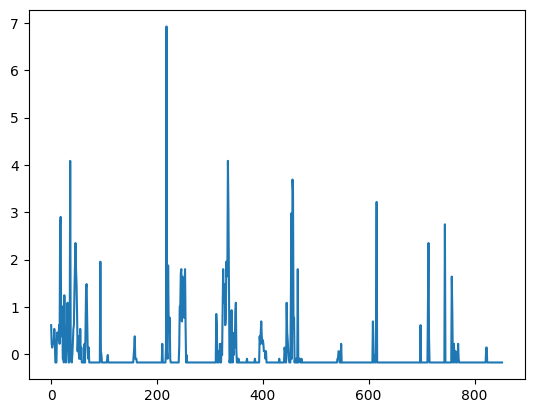

In [13]:
#~20% of Data as Validation Set
lenVal = int(len(gr_sc)*0.2)

#Training
gr_train = gr_sc[lenVal:]
ref_train = ref_sc[lenVal:]

#Validierung
gr_val = gr_sc[:lenVal]
ref_val = ref_sc[:lenVal]

print(gr_train.shape)
plt.plot(gr_val);

In [14]:
#reshape to (n,1)
in_train = np.stack([ref_train], axis=1)
print(in_train.shape)
in_val = np.stack([ref_val], axis=1)

(3415, 1)


### 2.2) Setup of a simple 3-layer Feedforward Neural Network

We use the keras

    sequential()

method to stack our layers.
First layer is the input layer. Here we define the dimensions of our feature vector (input of the model).
We specify the structure of the fully connected hidden layer (Dense) and of the output layer.

In the

    model.compile(options)

we specify the options for training (loss function, optimizer, metrics).

We use Early Stopping to prevent the model from overfitting.

In the 

    model.fit()
    
we specify the meta-parameters of training like number of epochs and batch size.

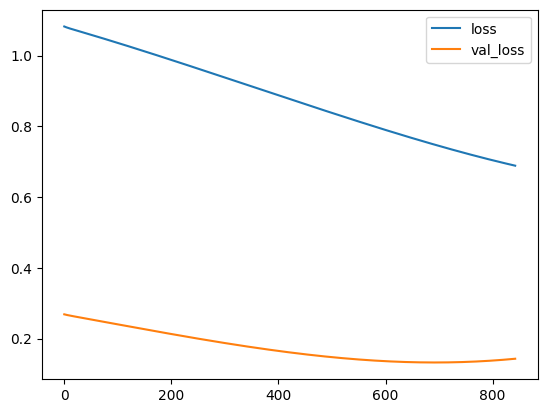

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9382 - mean_squared_error: 0.9382 - val_loss: 0.1430 - val_mean_squared_error: 0.1430
853/853 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 0.1774 - mean_squared_error: 0.1774


[0.15397164225578308, 0.15397164225578308]

In [15]:
from tensorflow.random import set_seed
set_seed(20)

# Define dimension of the Input Vector
inputdim=1

# Setup Model
MLP1 = Sequential()

# Input Layer - Input Dimension = 1
MLP1.add(Dense(inputdim , activation='linear', input_dim=inputdim))

# Fully Connected Hidden Layer with 20 Neurons and tanh activation
MLP1.add(Dense(50 , activation='tanh'))
#MLP1.add(Dense(10 , activation='tanh'))
#MLP1.add(Dense(5 , activation='relu'))
MLP1.add(Dense(1 , activation='linear'))

# Define the options for the different optimizers that are suitable for training
# SGD
sgd = SGD(learning_rate=0.0002, momentum=0.9, nesterov=True) 
# Adadelta
myadadelta=Adadelta(learning_rate=0.02, rho=0.95)
# Adam
myadam=Adam(learning_rate=0.02)

# Compile model
MLP1.compile(loss='mean_squared_error',
                          optimizer=myadadelta,
                          metrics=['mean_squared_error'])

# Set Options for early Stopping
# Should be used in callbacks if overfitting occurs
# Early Stopping
earlyStop = tensorflow.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error',
                                                     patience=150, 
                                                     restore_best_weights=True)
# Train Model
historyMLP1=MLP1.fit(in_train, gr_train, 
                      epochs=1000,
                      batch_size=200,
                      verbose=1, 
                      shuffle=True,
                      callbacks=[plot_losses, earlyStop],
                      validation_data=(in_val,gr_val))

# Evaluate on Validation set
scoreMLP1 = MLP1.evaluate(in_val,gr_val, batch_size=1)
scoreMLP1

The Loss curves show that the model is training well.

As soon as we have trained the model we can make predictions.  

### 2.3) Model Performance

We check the performance on the validation set:

In [15]:
data_out_usc = MLP1.predict(in_val)
MLP1_out_sc = data_out_usc*np.std(gr)+np.mean(gr)
#negativwerte entfernen
MLP1_out = np.where(MLP1_out_sc < 0, 0, MLP1_out_sc)

27/27 [==============================] - 0s 963us/step


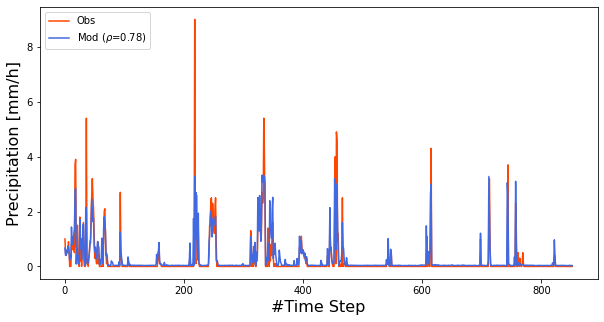

In [16]:
fig=plt.figure(figsize=(10, 5))

plt.plot(gr[:lenVal],'orangered',label='Obs')
plt.plot(MLP1_out,'royalblue',label='Mod ($ \\rho$=0.78)')

plt.ylabel('Precipitation [mm/h]', size=16)
plt.xlabel('#Time Step', size=16) 
#plt.title('Hohenpeissenberg - Validation (Hourly Data)', size=18)
plt.legend(loc='upper left');
plt.show()

fig.savefig('Plots/Ref_HourlySc_t=0.pdf', dpi=80)

...looks good :-)
    
Let's see what performance measdures we get:

In [17]:
MSE_MLP1=mean_squared_error(gr[:lenVal],MLP1_out.flatten())

bias_MLP1=np.mean(MLP1_out.reshape(1,-1))-np.mean(gr[:lenVal])

corr_MLP1=np.corrcoef(gr[:lenVal],MLP1_out.reshape(1,-1))[0,1]


print('bias:',bias_MLP1,'MSE:',MSE_MLP1,'corr:',corr_MLP1)

bias: 0.04533379773881202 MSE: 0.17464401387237505 corr: 0.8243168296914442


The scatter Plot shows some details:

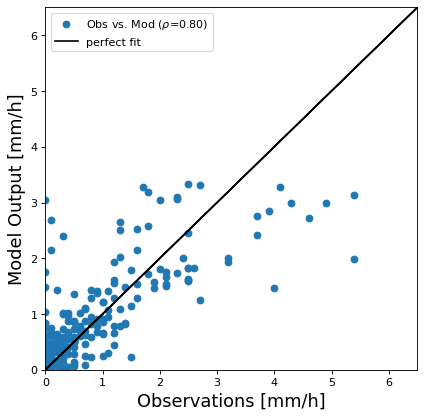

In [18]:
fig=plt.figure(figsize=(6, 6), dpi=80)
plt.xlim(0,6.5)
plt.ylim(0,6.5)

plt.scatter(gr[:lenVal],MLP1_out,label='Obs vs. Mod ($ \\rho$=0.80)');
plt.plot(gr[:lenVal],gr[:lenVal],'-',color='black',label='perfect fit');
plt.xlabel('Observations [mm/h]', size=16);
plt.ylabel('Model Output [mm/h]', size=16);
#plt.title('Validation (Hourly Data)', size=18);
plt.legend(loc='upper left');

fig.savefig('Plots/Scatter_HourlySc_t=0.pdf', dpi=80)

Compared to the Bias of the Z-R-solution the bias is slightly smaller.  

In addition to that, the performance in terms of the correlation is much better.  

We have increased the Pearson correlation from 0.63 (Z/R) to 0.80 - a big deal.  

### Exercise 1)

1) Try to optimize the results of the Simple FFNN
- change number of neurons
- optimize learning strategy (learning rate, learning rate schedule, optimizer...)

2) Is a deeper model better? Include more Dense layers

3) How does the activation function affect the result? 



## 3) Improvements

Now we have different possibilities to further increase our Models correction abilities:

### 1) include more useful information e.g. from time-lagged Radar information

#### Hypothesis 1:
The radar measures raindrops at about 2km height above ground.   
Thus we have a drift of the rain amount both in time and space. Therefore the rain amount observed by the radar at a specific time may fall to the ground only a time step later...  

#### Hypothesis 2: 
Other meteorological variables such as wind speed and direction or temperature will have an influence on the way how rain falls down from the radar observation region high above the ground. Therefore information about the overall weather conditions could help the model to adapt the precipitation amount...  

### 2) adapt the model structure

#### Hypothesis 1: 
The relationship between radar reflectivity and rainfall amount on the ground is highly non-linear.  
An increased complexity of the FFNN, i.e. deepness of the model, number of hidden neurons in the fully connected layers,... will help to model these highly non-linear relationships.  

#### Hypothesis 2: 
In general we have a time series model. FFNNs are not really able to take the time series structure of the data into account. A recurrent NN could be much more suitable to represent the time series structure of the underlying modeling task.

### 3.1) Recurrent NN - simple RNN & LSTM

we need the SimpleRNN and the LSTM Layers for our next experiments...

In [19]:
from tensorflow.keras.layers import SimpleRNN, LSTM

In [20]:
# Assuming X_in is a long time series with one variable
# and y_tar is the corresponding target vector

# Example data preparation
time_series_length = len(in_train)


# Reshape data for RNN 
# assuming a sequence length of 12 for each sample (history) is suitable
# defines the length of the history the model will see

sequence_length = 12
X_train = []
y_train = []

X_test = []
y_test = []

for i in range(len(in_train) - sequence_length):
    X_train.append(in_train[i:i+sequence_length])
    y_train.append(gr_train[i+sequence_length-1])

X_train = np.array(X_train)
y_train = np.array(y_train)

for i in range(len(in_val) - sequence_length):
    X_test.append(in_val[i:i+sequence_length])
    y_test.append(gr_val[i+sequence_length-1])

X_test = np.array(X_test)
y_test = np.array(y_test)

In [21]:
print(np.shape(X_test),np.shape(y_test))

(841, 12, 1) (841,)


Our data is now restructured:

841 samples of length 12 (non overlapping time periods, each time window is one input sample for the RNN).

This is a simple example how to setup a RNN Model.
It is not yet fine-tuned...

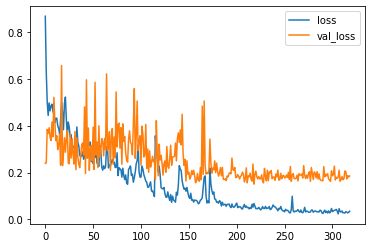

841/841 [==============================] - 1s 1ms/step - loss: 0.1503 - mean_squared_error: 0.1503


In [22]:
from tensorflow.random import set_seed
set_seed(20)

# Setup the RNN model
RNNmodel = Sequential()

# RNN Cell, Input dimension is length of history
RNNmodel.add(SimpleRNN(units=500, input_shape=(sequence_length, 1), activation='relu'))
RNNmodel.add(Dropout(0.1))

# RNN Cell 
RNNmodel.add(Dense(units=1, activation='linear'))

# Compile Model
RNNmodel.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='mean_squared_error',
                metrics=['mean_squared_error'])

# early stopping
earlyStop = keras.callbacks.EarlyStopping(monitor='val_mean_squared_error',
                                                     patience=100, 
                                                     restore_best_weights=True)
# learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=10, min_lr=1e-6)

# Train the Model
RNNmodel.fit(X_train, y_train, 
             epochs=1000,
             batch_size=200,
             verbose=1, 
             callbacks=[plot_losses, earlyStop,reduce_lr],
                      validation_data=(X_test,y_test))
 
# Evaluate Model
score = RNNmodel.evaluate(X_test,y_test, batch_size=1)


Rescale Model Predictions

In [23]:
data_out_usc_RNN = RNNmodel.predict(X_test)
RNN_out_sc = data_out_usc_RNN*np.std(gr)+np.mean(gr)
y_test_sc=y_test*np.std(gr)+np.mean(gr)
#Set negative Values to 0
RNN_out = np.where(RNN_out_sc < 0, 0, RNN_out_sc)

27/27 [==============================] - 0s 12ms/step


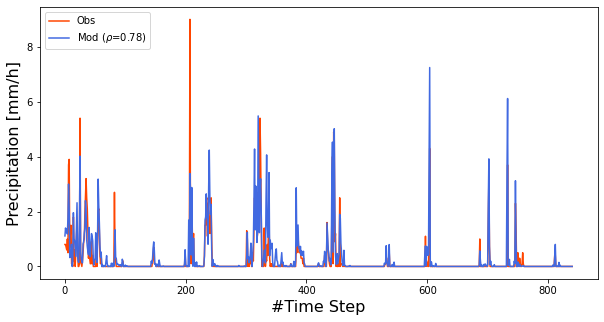

In [24]:
fig=plt.figure(figsize=(10, 5))

plt.plot(y_test_sc,'orangered',label='Obs')
plt.plot(RNN_out,'royalblue',label='Mod ($ \\rho$=0.78)')

plt.ylabel('Precipitation [mm/h]', size=16)
plt.xlabel('#Time Step', size=16) 
#plt.title('Hohenpeissenberg - Validation (Hourly Data)', size=18)
plt.legend(loc='upper left');
plt.show()



### 3.2) Analyze Performance

In [25]:
MSE_RNN=mean_squared_error(RNN_out.flatten(),y_test_sc)

bias_RNN=np.mean(RNN_out.flatten()-np.mean(y_test_sc))

corr_RNN=np.corrcoef(RNN_out.flatten(),y_test_sc)[0,1]


print('bias:',bias_RNN,'MSE:',MSE_RNN,'corr:',corr_RNN)

bias: 0.07230609 MSE: 0.24015286157980426 corr: 0.8012046658884151


### Exercise 2)

1) Try to optimize the results of the SimpleRNN
- change number of units
- optimize learning strategy (learning rate, learning rate schedule, optimizer...)

2) Use an LSTM-Block instead of the SimpleRNN and fine-tune the model

3) change the length of the history



## 4) Compare Modeling Results

In [26]:
# Assume you have collected metrics for each model
model_metrics=[['Metrics','Z-R','FFNN','SimpleRNN'],
              ['MSE',MSE_ZR,MSE_MLP1,MSE_RNN],
              ['Bias',bias_ZR,bias_MLP1,bias_RNN],
              ['Corr',corr_ZR,corr_MLP1,corr_RNN]]

# Create a DataFrame
model_comparison_df = pd.DataFrame(model_metrics)

# Display the DataFrame as a table
display(model_comparison_df)

,0,1,2,3
0,Metrics,Z-R,FFNN,SimpleRNN
1,MSE,1.16458,0.174644,0.240153
2,Bias,0.05523,0.045334,0.072306
3,Corr,0.635948,0.824317,0.801205


## Summary

We have shown that a simple Feedforward Neural Network is able to transform radar reflectivities to precipitation.

The use of a RNN (specifically designed for the modeling of time series) could further improve the result.

## Possible Improvements

Possible improvements:

1) Optimize the training of the Feedforward Network by adapted regularization procedures

2) Use additional input Features such as Time-Lagged information or additional meteorological variables

3) Use an ensemble of models to get an improved performance and assess for statistics of model uncertainty

4) establish a cascade of models that reduce the residual error step by step (boosting)

5) Implement sophisticated Recurrent Neural Network Topologies such as ECNN or HCNN specifically suitable for time-series modeling



## Challenges

In reality we will not only have to correct for bias in grid cells where observations are available. We want to correct the complete Radar field (also comprising cells without available ground observations).

### Question to think about: 
how can we transfer our NN model to get a FIELD of corrected Radar Precipitation?

The representation of precipitation fields by remote sensing is known to have not only a spatial but also a temporal offset compared to observations at the ground level

### Question to think about: 
what kind of ML-Model could we use and how would we have to set it up to take account of the spatio-teporal nature of the bias of radar Precipitation?